IMRT Beam Angle Optimization
==
Usando como base el solver `DAO_ILS`, la idea es crear un algoritmo que permita encontrar los mejores ángulos para realizar el tratamiento.

---
**Carga de librerías y conexión SSH**

In [1]:
import paramiko
import getpass
import numpy as np
import imrt

In [2]:
ssh = imrt.connect("158.251.88.197")

login: iaraya
pass: ········


----
Constructor imrt
---

Se carga la instancia remotamente generando las estructuras necesarias para ser usada. `max_voxels` es la cantidad máxima de voxels que se usa para representar un órgano. Limitar la cantidad permite probar los algoritmos más rápidamente.

Además carga localmente información de las instancias:

* cantidad de voxels por órgano (`nvoxels`)
* lista de ángulos (`angles`)
* cantidad de beamlets y valid shapes por ángulos (`angle2nbeamlets`)

In [3]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/Equidistantes/equidist.txt", "data/Equidistantes/equidist-coord.txt"], ssh, max_voxels=500, port=8050)

killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/Equidistantes/equidist.txt --file-coord=data/Equidistantes/equidist-coord.txt --tabu-size=200 --seed=3 --min_impr=0.05 --vsize=0.002 --max_voxels=500 --path=/home/iaraya/imrt --port=8050
ready



----
init_fluence_map
--

Carga el fluence map con el BAC (beam angle configuration) asociado.
Retorna la evaluación correspondiente.

In [4]:
instance.init_fluence_map(fluence_map=[], bac=[0, 175, 245, 315])

echo init_fluence_map 4 0 175 245 315  | netcat localhost 8050


28880.0

----
iterated_local_search (`DAO_ILS`)
---

Realiza una búsqueda local usando dos vecindarios y retorna la evaluación de la solución encontrada (y la cantidad de iteraciones realizada). Usa los siguientes tipos de movimiento:

* *beam_intensity move*: modifica un beamlet de un fluence map matrix (existe la opción *targeted* para ordenar los movimientos)
* *level_intensity move*: modifica un nivel de intensidad de la matriz

In [5]:
instance.iterated_local_search()

(37.6712, 3622)

----
get_fluence_map
--
Retorna la solución del problema (fluence map vector)

In [6]:
fm = instance.get_fluence_map()
fm[0]

array([10,  3,  3, 10,  9,  9,  3,  1,  1, 10, 10,  9,  9,  9,  9,  8,  1,
        1,  7, 10,  9,  9,  9,  8,  7,  3,  0, 10, 10,  9,  9,  9,  8,  8,
        8,  1,  9, 10, 10, 10,  9,  9,  9,  9,  0, 10, 10, 10, 10, 10, 10,
       10,  3,  0,  8, 10, 10, 10, 10, 10,  7,  3, 10, 10,  9,  3,  0,  0,
        1,  3])

----
fm2matrix
--

Obtiene la matriz de intensidades de un ángulo a partir del *fluence map vector*.

In [7]:
Y = instance.fm2matrix(fm[0], 0)

En el siguiente ejemplo se grafica la matriz de intensidades para cada ángulo en el bac.

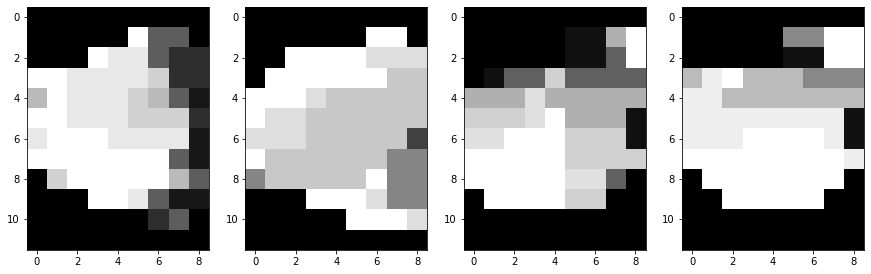

In [8]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image as im 

%matplotlib inline
fig=plt.figure(figsize=(15, 10))

i=1
for angle in instance.bac:
    array = instance.fm2matrix(fm[i-1],angle)
    fig.add_subplot(1, len(instance.bac), i)
    plt.imshow(array,cmap='gray')
    i += 1

plt.show()

----
get_dose_vectors
--

Retorna un vector de dosis irradiada a cada órgano por la solución (fluence map) actual.

In [9]:
dose_vectors = instance.get_dose_vectors()
for v in dose_vectors:
    print(v.shape)

(500,)
(500,)
(500,)


Aquí obtenemos un gráfico que muestra la proporción de voxels (y) que recibe al menos una dosis x.
Dosis prescrita para el tumor: 76 
Dosis recomendada para los órganos: menos a 65

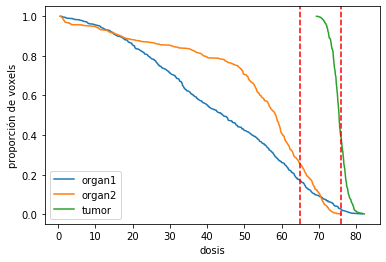

In [10]:
dose_vectors[0][::-1].sort()
index0 = (np.arange(len(dose_vectors[0]))+1)/len(dose_vectors[0])
dose_vectors[1][::-1].sort()
index1 = (np.arange(len(dose_vectors[1]))+1)/len(dose_vectors[1])
dose_vectors[2][::-1].sort()
index2 = (np.arange(len(dose_vectors[2]))+1)/len(dose_vectors[2])
plt.xlabel('dosis')
plt.ylabel('proporción de voxels')
plt.plot(dose_vectors[0], index0, '-' , dose_vectors[1], index1, '-' ,dose_vectors[2], index2, '-')
plt.axvline(x=65, color='r', linestyle='--')
plt.axvline(x=76, color='r', linestyle='--')
plt.legend(['organ1', 'organ2', 'tumor'], loc='best')

Indicadores clínicos
----

- $D_{x}$: Dosis recibida por el x% del tumor/órgano
- $D_{max}$: Máxima dosis recibida por el tumor/órgano
- $D_{mean}$: Dosis promedio recibida por el tumor/órgano
- $V_{x}$: Voxels que reciben al menos x% de la dosis

In [11]:
def D(dose_vector, x=95): return dose_vector[int(len(dose_vector)*x/100)]
def Dmax(dose_vector): return np.max(dose_vector)
def Dmean(dose_vector): return np.mean(dose_vector)
def V(dose_vector, dose=0.95*76): return np.argmax(dose_vector < dose)/len(dose_vector)

print("D_95 (tumor): ", D(dose_vectors[2],x=95))
print("Dmax (organ1): ", Dmax(dose_vectors[0]))
print("Dmean (organ2): ", Dmean(dose_vectors[1]))
print("V_95 (tumor): ", V(dose_vectors[2], dose=0.99*76))

D_95 (tumor):  72.126
Dmax (organ1):  81.6768
Dmean (organ2):  51.888566458
V_95 (tumor):  0.548


---
Otras funcionalidades
---

**matrix2fm**

Pasa una matrix a fluence_map asociado a un ángulo.

Note que si el angulo es distinto al original, el resultado puede no ser válido.

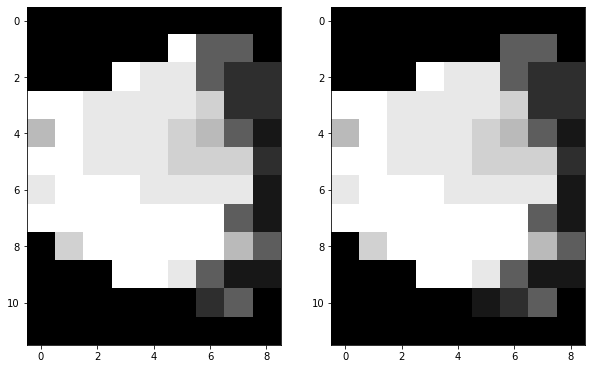

In [12]:
fig=plt.figure(figsize=(10, 10))


array = instance.fm2matrix(fm[0],0)
fig.add_subplot(1, 2, 1)
plt.imshow(array,cmap='gray')

fm_new = instance.matrix2fm(Y, 5) # ángulo original es 0 y cambió a 5
array = instance.fm2matrix(fm_new,5)
fig.add_subplot(1, 2, 2)
plt.imshow(array,cmap='gray')

plt.show()

Para llamar a la función `init_fluence_map` con una lista de fluence maps, tenemos que concatenarlas así `np.concatenate(tuple(fluence_maps)`

In [13]:
instance.init_fluence_map(np.concatenate(tuple(fm)), bac=[5, 175, 245, 315])

echo init_fluence_map 4 5 175 245 315 10 3 3 10 9 9 3 1 1 10 10 9 9 9 9 8 1 1 7 10 9 9 9 8 7 3 0 10 10 9 9 9 8 8 8 1 9 10 10 10 9 9 9 9 0 10 10 10 10 10 10 10 3 0 8 10 10 10 10 10 7 3 10 10 9 3 0 0 1 3 22 22 22 22 22 22 19 19 19 22 22 22 22 22 22 17 17 22 22 22 19 17 17 17 17 17 22 19 19 17 17 17 17 17 17 19 19 19 17 17 17 17 17 5 22 17 17 17 17 17 17 11 11 11 17 17 17 17 17 22 11 11 22 22 22 19 11 11 22 22 22 19 0 0 10 15 0 0 5 15 0 5 5 12 5 5 5 5 10 10 10 13 10 10 10 10 10 12 12 12 13 15 10 10 10 0 13 13 15 15 15 12 12 12 0 15 15 15 15 15 12 12 12 12 15 15 15 15 15 13 13 5 15 15 15 15 12 12 7 7 14 14 0 0 14 14 10 13 14 10 10 10 7 7 7 13 13 10 10 10 10 10 10 10 13 13 13 13 13 13 13 13 0 13 13 13 14 14 14 14 13 0 14 14 14 14 14 14 14 14 13 14 14 14 14 14 14 14 14 14 14 14 14 | netcat localhost 8050


71.2481

Note que al comenzar de un buen fluence map para un ángulo vecino, la búsqueda local converge mucho más rápido:

In [14]:
instance.iterated_local_search()

(38.006, 2911)

---
**get_deposition_matrix**

Sea $M$ una matriz de deposición para un órgano $organ$ y ángulo $angle$.

$M[k][b]$ indica la dosis irradiada por un beamlet $b$ del ángulo $angle$ en el voxel $k$ del órgano $organ$.

In [15]:
M = instance.get_deposition_matrix(2, 0)

Se imprimen la dosis a los voxels vs los beamlets (se ordenan los beamlets desde el que causa mayor impacto)

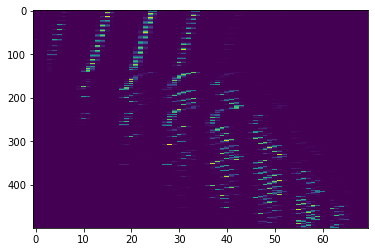

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()
plt.imshow(M,interpolation='none', aspect='auto')

In [17]:
M[76,0] # impacto del beamlet 0 en el voxels 76

0.00211954

In [18]:
np.argsort(-M[:,0])[0:20] #voxels más impactado por beamlet 0

array([55, 67, 22, 44, 33, 68, 56, 91, 45, 23, 34, 57, 46, 80, 69, 13, 24,
       35, 92, 81], dtype=int64)

In [19]:
np.argsort(-M[76,:])[0:20] #beamlets con mayor impacto en voxel 76

array([22, 31, 23, 32, 30, 21, 13, 14, 24, 39, 12, 15, 50, 34, 25, 11, 43,
       52,  7, 26], dtype=int64)